### Lectura de log central

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import dotenv_values
import os

sysConfig = dotenv_values(".env")
ventana_tiempo = sysConfig.get('TIME_GAP', '1s')

# Cargar el archivo de texto
df = pd.read_csv('../rmi/server/logServer.csv', 
                 sep=', ', 
                 engine='python', 
                 header=None, 
                 names=['timestamp', 'operation', 'game', 'action', 'team', 'player', 'result'])

df["timestamp"] = pd.to_datetime(df["timestamp"], dayfirst=True)

print(df)

             timestamp operation    game        action  team  player result
0  2024-06-21 22:09:01       ini  juego1  inicio-juego  None    None   None
1  2024-06-21 22:09:17       ini  juego1  crea-jugador     a     isi   None
2  2024-06-21 22:09:17       fin  juego1  crea-jugador     a     isi   True
3  2024-06-21 22:09:23       ini  juego1    lanza-dado     a     isi      6
4  2024-06-21 22:09:23       fin  juego1    lanza-dado     a     isi      6
5  2024-06-21 22:09:24       fin  juego1     fin-juego  None    None   None
6  2024-06-21 22:08:59       ini  juego1  inicio-juego  None    None   None
7  2024-06-21 22:09:20       ini  juego1  crea-jugador     b    kris   None
8  2024-06-21 22:09:20       fin  juego1  crea-jugador     b    kris   True
9  2024-06-21 22:09:21       ini  juego1    lanza-dado     b    kris      5
10 2024-06-21 22:09:21       fin  juego1    lanza-dado     b    kris      5
11 2024-06-21 22:09:24       ini  juego1    lanza-dado     b    kris      6
12 2024-06-2

### Problema 1

In [72]:
players_per_team = df[["game","team","player"]].groupby(["game", "team"]).aggregate(lambda x: len(np.unique(x))).reset_index()
players_per_team

,game,team,player
0,juego1,a,1
1,juego1,b,1
2,juego2,a,1
3,juego2,b,2
4,juego2,c,1
5,juego2,d,1


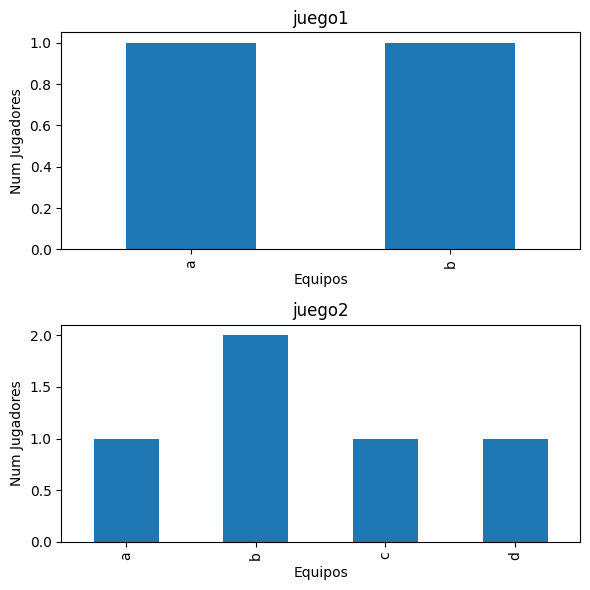

In [73]:
games = len(players_per_team['game'].unique())

fig, axes = plt.subplots(nrows=len(players_per_team['game'].unique()), figsize=(6, 3*games))

# Iterar sobre cada juego y crear un subplot
for i, (game, data_game) in enumerate(players_per_team.groupby('game')):
    ax = axes[i]
    data_game.set_index('team')['player'].plot(kind='bar', ax=ax)
    ax.set_title(game)
    ax.set_xlabel('Equipos')
    ax.set_ylabel('Num Jugadores')

plt.tight_layout()
plt.show()

### Problema 2

In [74]:
df_roll = df.loc[(df['action'] == 'lanza-dado') & (df['operation'] == 'fin')]
df_games = df_roll.groupby(['game', 'player']).size().reset_index(name='num_jugadas')
df_games

,game,player,num_jugadas
0,juego1,isi,1
1,juego1,kris,2
2,juego2,gataxl,2
3,juego2,isi,1
4,juego2,kris,2
5,juego2,rata,3
6,juego2,xd,3


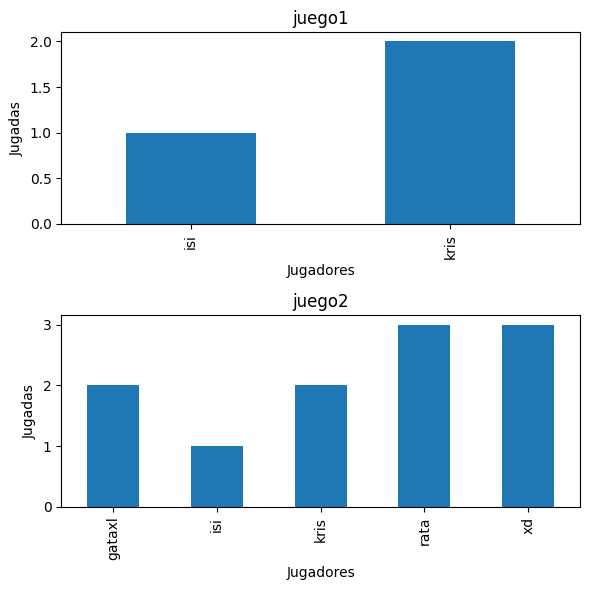

In [75]:
games = len(df_games['game'].unique())

fig, axes = plt.subplots(nrows=games, figsize=(6, 3*games))

for i, (game, data_game) in enumerate(df_games.groupby('game')):
    ax = axes[i]
    data_game.set_index('player')['num_jugadas'].plot(kind='bar', ax=ax)
    ax.set_title(game)
    ax.set_xlabel('Jugadores')
    ax.set_ylabel('Jugadas')

plt.tight_layout()
plt.show()

### Problema 3

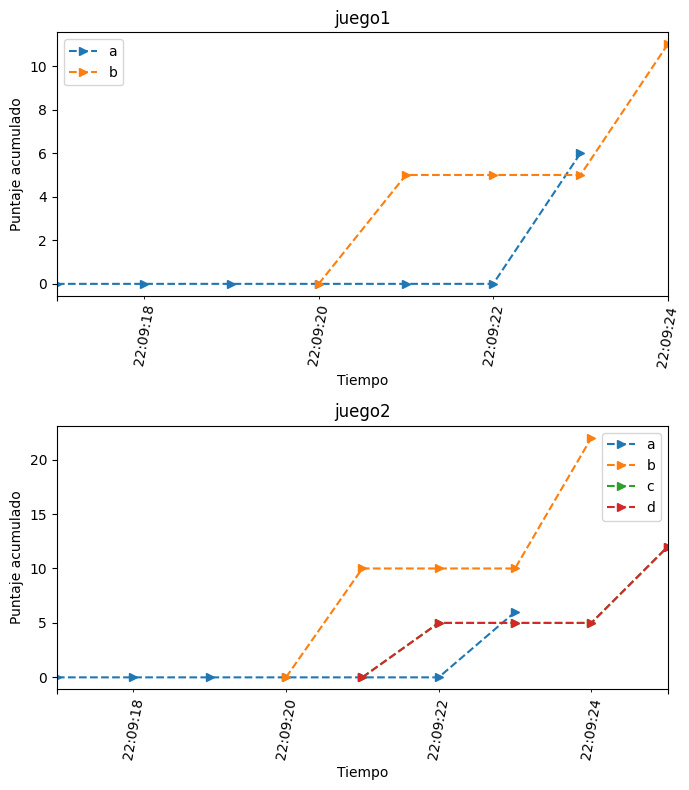

In [76]:
dffiltered = df[(df["action"] == "lanza-dado") & (df["operation"] == "fin")]\
    [["timestamp","game","team","result"]].dropna()
dffiltered = dffiltered.sort_values(by="timestamp")

n_games = len(np.unique(dffiltered["game"])) # numero total de juegos

fig, ax = plt.subplots(nrows=n_games, figsize=(7, 4*n_games))
if n_games == 1: ax = [ax]

for i, game in enumerate(np.unique(dffiltered["game"])):
    dfr = dffiltered[dffiltered["game"] == game]
    
    teams = np.unique(dfr["team"])
    for team in teams:
        dfteam = dfr[dfr["team"] == team]
        dfteam = dfteam[["timestamp", "result"]].groupby("timestamp") \
            .agg(lambda x: np.sum(pd.to_numeric(x))).reset_index()

        # añade resultado 0 a primera vez que aparecio el equipo
        dfteam.loc[len(dfteam)] = {
            "timestamp": pd.Timestamp(str(df[["timestamp", "team"]][df["team"] == team]\
                                          .groupby("team").first().values.squeeze())), 
            "result": 0
            }
        
        # samplea intervalos y genera plot de equipo en juego correspondiente
        dfteam.set_index("timestamp").resample(ventana_tiempo).sum().cumsum()\
            .plot(ax=ax[i], linestyle="--", marker=">")
        
    ax[i].legend(teams)
    ax[i].set_title(game)
    ax[i].set_ylabel("Puntaje acumulado")
    ax[i].set_xlabel("Tiempo")
    ax[i].tick_params(axis='x', which="both", labelrotation=80)

plt.tight_layout()

### Problema 4

In [77]:
equipos_creados =df[['game','team', 'timestamp']].groupby(["game", "team"]).first().reset_index()
equipos_creados.set_index('timestamp', inplace=True)
equipos_creados

,game,team
timestamp,,
2024-06-21 22:09:17,juego1,a
2024-06-21 22:09:20,juego1,b
2024-06-21 22:09:17,juego2,a
2024-06-21 22:09:20,juego2,b
2024-06-21 22:09:21,juego2,c
2024-06-21 22:09:21,juego2,d


In [78]:
equipos_por_tiempo = equipos_creados.groupby('game').resample(ventana_tiempo).size().reset_index(name='count')

equipos_por_tiempo['cumulative_count'] = equipos_por_tiempo.groupby('game')['count'].cumsum()

print(equipos_por_tiempo)

     game           timestamp  count  cumulative_count
0  juego1 2024-06-21 22:09:17      1                 1
1  juego1 2024-06-21 22:09:18      0                 1
2  juego1 2024-06-21 22:09:19      0                 1
3  juego1 2024-06-21 22:09:20      1                 2
4  juego2 2024-06-21 22:09:17      1                 1
5  juego2 2024-06-21 22:09:18      0                 1
6  juego2 2024-06-21 22:09:19      0                 1
7  juego2 2024-06-21 22:09:20      1                 2
8  juego2 2024-06-21 22:09:21      2                 4


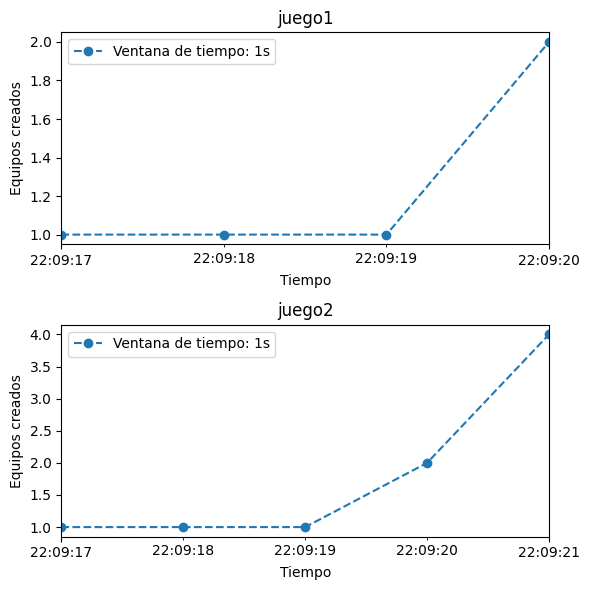

In [79]:
games = len(equipos_por_tiempo['game'].unique())
fig, axes = plt.subplots(nrows=games, figsize=(6, 3*games))

for i, (game, data_game) in enumerate(equipos_por_tiempo.groupby('game')):
    ax = axes[i]
    data_game.set_index('timestamp')['cumulative_count'].plot(kind='line', ax=ax, label=f'Ventana de tiempo: {ventana_tiempo}', marker='o', linestyle='--')
    ax.set_title(game)
    ax.set_xlabel('Tiempo')
    ax.set_ylabel('Equipos creados')
    ax.legend()

plt.tight_layout()
plt.show()

### Problema 5

In [80]:
jugadores_creados =df[['game','player', 'timestamp']].groupby(["game", "player"]).first().reset_index()
jugadores_creados.set_index('timestamp', inplace=True)
jugadores_creados

,game,player
timestamp,,
2024-06-21 22:09:17,juego1,isi
2024-06-21 22:09:20,juego1,kris
2024-06-21 22:09:20,juego2,gataxl
2024-06-21 22:09:17,juego2,isi
2024-06-21 22:09:20,juego2,kris
2024-06-21 22:09:21,juego2,rata
2024-06-21 22:09:21,juego2,xd


In [81]:
jugadores_por_tiempo = jugadores_creados.groupby('game').resample(ventana_tiempo).size().reset_index(name='count')

jugadores_por_tiempo['cumulative_count'] = jugadores_por_tiempo.groupby('game')['count'].cumsum()

print(jugadores_por_tiempo)

     game           timestamp  count  cumulative_count
0  juego1 2024-06-21 22:09:17      1                 1
1  juego1 2024-06-21 22:09:18      0                 1
2  juego1 2024-06-21 22:09:19      0                 1
3  juego1 2024-06-21 22:09:20      1                 2
4  juego2 2024-06-21 22:09:17      1                 1
5  juego2 2024-06-21 22:09:18      0                 1
6  juego2 2024-06-21 22:09:19      0                 1
7  juego2 2024-06-21 22:09:20      2                 3
8  juego2 2024-06-21 22:09:21      2                 5


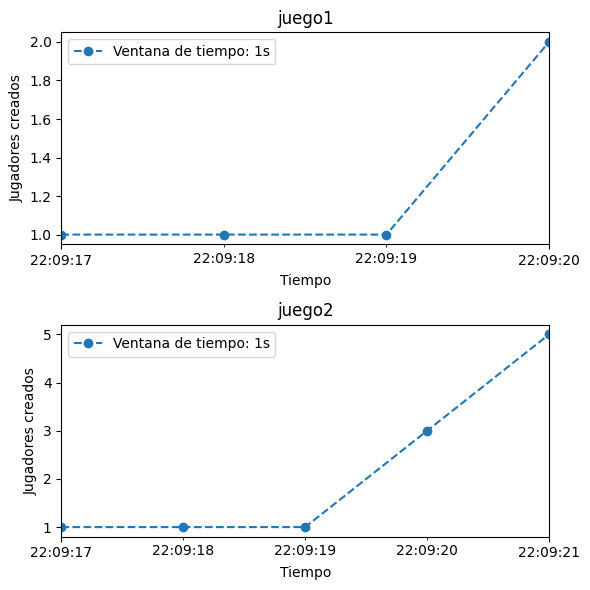

In [82]:
games = len(jugadores_por_tiempo['game'].unique())
fig, axes = plt.subplots(nrows=games, figsize=(6, 3*games))

for i, (game, data_game) in enumerate(jugadores_por_tiempo.groupby('game')):
    ax = axes[i]
    data_game.set_index('timestamp')['cumulative_count'].plot(kind='line', ax=ax, label=f'Ventana de tiempo: {ventana_tiempo}', marker='o', linestyle='--')
    ax.set_title(game)
    ax.set_xlabel('Tiempo')
    ax.set_ylabel('Jugadores creados')
    ax.legend()

plt.tight_layout()
plt.show()